# Introduction

This is a sentiment analysis project on the datasets from Dr. Hibo Je and Kaggle, performed the analysis by merging and
 pre-processing both the datasets by leveraging pre-trained GloVe embeddings and fine-tuning them for optimal word
 representation. Developed and implemented both Bi-LSTM and Transformer models to predict quality and difficulty scores,
 rigorously evaluating their performance using accuracy, loss metrics, and confusion matrices. Bi-LSTM demonstrated superior
 performance, particularly in scenarios with limited data. A key challenge arose in detecting sarcasm and ambiguous
 comments, leading to misclassification. This was effectively resolved by integrating sentiment-specific embeddings and
 contextual features, which significantly enhanced the models' ability to interpret and classify nuanced sentiments with greater
 accuracy.

# Steps performed

    Importing Required Libraries
        --Imported essential libraries including os, glob, re, nltk, json, pandas, and tensorflow.

    DATA PROCESSING

        --Data from Dr. Hibo's zip file
            Merged multiple CSV files from a zip file.
            Pre-processed the merged data for further analysis.
            Displayed the first few rows of the processed data.

        --CSV from Dr. Je's Dataset
            Pre-processed the data from the provided CSV file.
            Displayed the first few rows of the processed data.

        --CSV file generated from Kaggle JSON file
            Loaded data from a CSV file generated from a Kaggle JSON dataset.
            Displayed the first few rows of the processed data.
            Emphasized the use of student comments for sentiment analysis.

        --Extracting Comments to X from the three data sources
            Extracted comments from the three different datasets for analysis.

        --Extracting Difficulty from the three data sources
            Extracted difficulty ratings from the three different datasets.

        --Extracting Quality from the three data sources
            Extracted quality ratings from the three different datasets.

       -- Merging all the extracted information
            Merged comments, quality ratings, and difficulty ratings from all datasets.

    WORD EMBEDDINGS
        -- Implemted word embedings using GloVe embedding

    Bi-LSTM on Quality and Difficulty
        --Trained a Bi-LSTM model on difficulty ratings.
        --Evaluated the quality model on test data.
        --Defined a function to plot training history.
        --Generated confusion matrices for quality and difficulty predictions using the Bi-LSTM model.

    TRANSFORMER
        --Defined the transformer encoder and custom transformer model.
        --Compiled transformer models for quality and difficulty predictions.
        --Trained the transformer model on quality and difficulty datasets.
        --Evaluated the transformer models on test data.
        --Plotted the training history for the transformer models.
        --Generated confusion matrices for quality and difficulty predictions   
          using the transformer model.


# **Importing Required Libraries**

In [ ]:
import os
import glob
import re
import nltk
import json


import pandas as pd
import tensorflow as tf
import numpy as np

from numpy import array, asarray, zeros
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.lm.preprocessing import pad_sequence

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input,Flatten, GlobalMaxPooling1D, Embedding, Conv1D,LSTM, Bidirectional,MaxPooling1D, BatchNormalization
from keras.layers import Activation, Dropout, Dense, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **DATA PROCESSING**

The files required for this step are [here](https://drive.google.com/drive/folders/1wD7pOe_vFzyiIDicxMlfN0bMqePwuDNs?usp=drive_link):

#**Data from Dr. Hibo je zip file**

**Merging All CSV files in zip file**

THis step is not required if you already have the 'merged_data' file in your folder



In [ ]:
file_path = "/content/drive/MyDrive/CPSC_585_project-3/RateMyProfessor SampleData, Contact hejibo@usee.tech for the whole 5G dataset"
csv_files = glob.glob(f"{file_path}/*.csv")
reviews = pd.concat([pd.read_csv(f) for f in csv_files ], ignore_index=True)
reviews.to_csv('/content/drive/MyDrive/CPSC_585_project-3/merged_data.csv')

**Pre-processing data from Dr.Je zip file**

In [ ]:
merged_data  = pd.read_csv("/content/drive/MyDrive/CPSC_585_project-3/merged_data.csv")
merged_data = merged_data.loc[:,["comments", "student_star", "student_difficult"]]
merged_data = merged_data.dropna()

**Observing processed Data**

In [ ]:
merged_data.head()

,comments,student_star,student_difficult
0,Truly an awful experience. An exceptionally la...,1.0,5.0
1,This class was decent at best. Lynette is know...,2.0,3.0
2,I am in class with her this semester and I fin...,2.5,3.0
3,"Good instructor, but drastically different sty...",3.0,4.0
4,.,1.0,1.0


# **CSV from Dr.Je's Dataset**

**Pre-processing data**

In [ ]:
csv_data = pd.read_csv("/content/drive/MyDrive/CPSC_585_project-3/RateMyProfessor_Sample data.csv")
csv_data = csv_data.loc[:,["comments", "student_star", "student_difficult"]]
csv_data = csv_data.dropna()

**Observing processed Data**

In [ ]:
csv_data.head()

,comments,student_star,student_difficult
0,"This class is hard, but its a two-in-one gen-e...",5.0,3.0
1,Definitely going to choose Prof. Looney\'s cla...,5.0,2.0
2,I overall enjoyed this class because the assig...,4.0,3.0
3,"Yes, it\'s possible to get an A but you\'ll de...",5.0,3.0
4,Professor Looney has great knowledge in Astron...,5.0,1.0


# **CSV file generated from kaggle JSON file**

In [ ]:
kaggle_data = pd.read_csv("/content/drive/MyDrive/CPSC_585_project-3/kaggle.csv")

In [ ]:
kaggle_data.head()

,course_id,Quality,Difficulty,For Credit,Attendance,Would Take Again,Grade,Textbook,Comment,professor,department
0,FHS010,5.0,2,Yes,NaN,Yes,A,No,Professor Nichols is super nice and very whole...,James Nichols,Government department
1,FHS010,3.0,1,Yes,Mandatory,No,NaN,No,"Very chill class and teacher, very easy grader...",James Nichols,Government department
2,POLPHILOSOPHY,4.0,1,Yes,NaN,NaN,NaN,Yes,"Awesome, easy, knows literally everything abou...",James Nichols,Government department
3,FHS010,5.0,2,NaN,NaN,NaN,NaN,Yes,Prof. Nichols is a super nice and encouraging ...,James Nichols,Government department
4,FHS10,5.0,1,NaN,NaN,NaN,NaN,Yes,Good Professor. Really nice and encouraging te...,James Nichols,Government department


As We are trying to perform sentiment analysis using the sudents comments, we need to use the comments as input and the predictions should be the quality and difficulty so we need to first extract the comments to be x and quality and difficuty to be y

**Extracting Comments to X from the three data sources**

In [ ]:
X1 = merged_data.iloc[:,0].values
X2 = csv_data.iloc[:,0].values
X3 = kaggle_data.iloc[:,8].values

**Extracting Difficuly from the three data sources**

In [ ]:
Y_d1 = merged_data.iloc[:,1:2].values
Y_d2 = csv_data.iloc[:,1:2].values
Y_d3 = kaggle_data.iloc[:,1:2].values

 **Extracting Quality from the three data sources**

In [ ]:
Y_q1 = merged_data.iloc[:,1:2].values
Y_q2 = csv_data.iloc[:,1:2].values
Y_q3 = kaggle_data.iloc[:,1:2].values

**Merging all the extraxcted information**

In [ ]:
X = np.concatenate((X1, X2))
Y_quality = np.concatenate((Y_q1,Y_q2))
Y_difficulty = np.concatenate((Y_d1, Y_d2))
X = np.concatenate((X, X3))
Y_quality = np.concatenate((Y_quality, Y_q3))
Y_difficulty = np.concatenate((Y_difficulty, Y_d3))

In [ ]:
print("Shapes:")
print(f"X = {X.shape}")
print(f"Quality = {Y_quality.shape}")
print(f"Difficulty = {Y_difficulty.shape}")

Shapes:
X = (34063,)
Quality = (34063, 1)
Difficulty = (34063, 1)


In [ ]:
print(X,Y_quality,Y_difficulty)

["A terrible experience all together. Extremely condescending and never had anything nice to say to anyone. He made it really hard to enjoy the class and although I love painting, I couldn\\'t stand going. He was just rude and I would highly recommend avoiding him."
 "Condescending, pretentious, and overall an awful experience. Didn\\'t teach me anything and was just rude about everything and anything. Save your time and money."
 "At first i wanted to quit this course but i pulled through and it wasn\\'t so bad. i definitely discovered my drawing potential. BEWARE- HARD GRADER. i was sure i was getting a definite A+, but at the end, i got an A-, im not one to complain about an A- but this one was unjustified; i feel like he wouldnt give an a+ unless youre picasso"
 ...
 'Too stringent with following the rules, nearly to the point of being anti-compassionate.  Reasonably clear with expectations, but not very approachable.'
 'Psych is such BS!'
 "This class is less focused on politics th

**Text Processing**

As we can see from the output above, we have the comments and we need to strip the comments from charecters like punchuations, stopwords, numbers, single-character words, empty strings and extra spaces that do not help us in analysing the quality or the difficuly of the class. so we define the preprocess_text function that does that for us and we apply it on our input X.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

def text_processing(text):

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove single characters
    text = re.sub(r'\b[a-z]\b', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
comments = [text_processing(sen) for sen in X]

print("X shape: ", np.shape(X))
print("Comments size: ", np.size(comments))

X shape:  (34063,)
Comments size:  34063


In [ ]:
for comment in comments[:10]:
    print(comment)

terrible experience together extremely condescending never anything nice say anyone made really hard enjoy class although love painting couldnt stand going rude would highly recommend avoiding
condescending pretentious overall awful experience didnt teach anything rude everything anything save time money
first wanted quit course pulled wasnt bad definitely discovered drawing potential beware hard grader sure getting definite end got im one complain one unjustified feel like wouldnt give unless youre picasso
might worlds greatest teacher definitely became better artist end class first really confused wanted give majoring fine arts completely one class took step back really clarified things helped lot improved greatly would recommend teacher
horrible pretentious impossible please nothing help artwork badmouths instead giving constructive criticism would say plays favorites doesnt seem like anyone classes personally lost interest art stopped art major
nuno needs lighten get laid hes sooo 

In [ ]:
text = " ".join(comments)

**Generate the word cloud**

The Word Cloud visualization to provide an intuitive visual summary of the most frequent words in a text corpus. Words in the word cloud are mapped to font sizes based on their frequency. More frequent words are assigned larger font sizes.

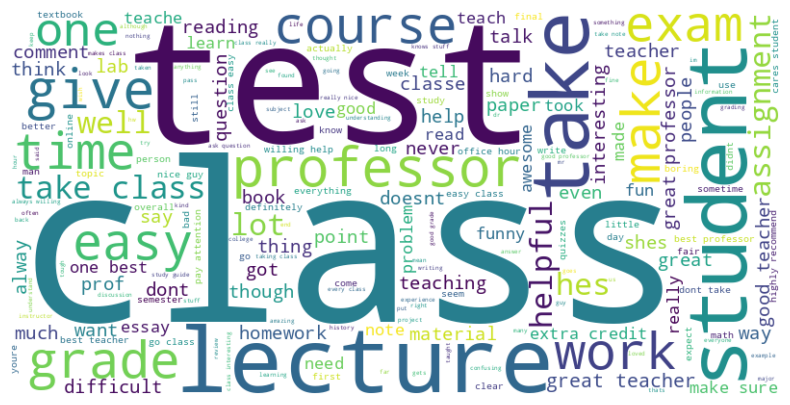

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

From the word cloud generated words such as "class," "test," "lecture," "professor," and "student" appear to be dominant. The presence of terms like "easy," "grade," "give," "take," "course," "time," "exam," "homework," "material," "problem," "helpful," "difficult," and "assignment" suggests that our data considers the mentioned factors in associating to the difficulty, quality of the course.

**Spltting the data**

In [ ]:
test_size_ratio = 0.2
valid_size_ratio = 0.2

# Split for Quality
X_quality_train, X_quality_test, y_quality_train, y_quality_test = train_test_split(comments, Y_quality, test_size=test_size_ratio, random_state=42)
X_quality_train, X_quality_valid, y_quality_train, y_quality_valid = train_test_split(X_quality_train, y_quality_train, test_size=valid_size_ratio, random_state=42)

# Split for Difficulty
X_difficulty_train, X_difficulty_test, y_difficulty_train, y_difficulty_test = train_test_split(comments, Y_difficulty, test_size=test_size_ratio, random_state=42)
X_difficulty_train, X_difficulty_valid, y_difficulty_train, y_difficulty_valid = train_test_split(X_difficulty_train, y_difficulty_train, test_size=valid_size_ratio, random_state=42)

# Print the shapes of the resulting datasets
print("Quality - Training shape:", len(X_quality_train), y_quality_train.shape)
print("Quality - Validation shape:", len(X_quality_valid), y_quality_valid.shape)
print("Quality - Test shape:", len(X_quality_test), y_quality_test.shape)

print("Difficulty - Training shape:", len(X_difficulty_train), y_difficulty_train.shape)
print("Difficulty - Validation shape:", len(X_difficulty_valid), y_difficulty_valid.shape)
print("Difficulty - Test shape:", len(X_difficulty_test), y_difficulty_test.shape)

Quality - Training shape: 21800 (21800, 1)
Quality - Validation shape: 5450 (5450, 1)
Quality - Test shape: 6813 (6813, 1)
Difficulty - Training shape: 21800 (21800, 1)
Difficulty - Validation shape: 5450 (5450, 1)
Difficulty - Test shape: 6813 (6813, 1)


**Tokenizing the comments**

Now after the split we need to get a set of words to create an embedding, so in this step we use the inbuilt Tokenizaer in Keras

In [ ]:
word_tokenizer = Tokenizer()

word_tokenizer.fit_on_texts(X_quality_train)
word_tokenizer.fit_on_texts(X_difficulty_train)

X_quality_train = word_tokenizer.texts_to_sequences(X_quality_train)
X_quality_test = word_tokenizer.texts_to_sequences(X_quality_test)
X_quality_valid = word_tokenizer.texts_to_sequences(X_quality_valid)

X_difficulty_train = word_tokenizer.texts_to_sequences(X_difficulty_train)
X_difficulty_test = word_tokenizer.texts_to_sequences(X_difficulty_test)
X_difficulty_valid = word_tokenizer.texts_to_sequences(X_difficulty_valid)




We are increaing the size of to accomodate the addition of unkown words.

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

20646

Next we perform the padding operation, Padding sequences with empty strings or a special padding token ensures that all input sequences have uniform lengths, which is essential for batch processing in machine learning models. This approach, combined with masking, allows models to handle variable-length sequences effectively without being influenced by the padding tokens.


In [ ]:
max_len = 100
X_quality_train = tf.keras.preprocessing.sequence.pad_sequences(X_quality_train, maxlen=max_len, padding='post')
X_quality_test = tf.keras.preprocessing.sequence.pad_sequences(X_quality_test, maxlen=max_len, padding='post')
X_quality_valid = tf.keras.preprocessing.sequence.pad_sequences(X_quality_valid, maxlen=max_len, padding='post')

X_difficulty_train = tf.keras.preprocessing.sequence.pad_sequences(X_difficulty_train, maxlen=max_len, padding='post')
X_difficulty_test = tf.keras.preprocessing.sequence.pad_sequences(X_difficulty_test, maxlen=max_len, padding='post')
X_difficulty_valid = tf.keras.preprocessing.sequence.pad_sequences(X_difficulty_valid, maxlen=max_len, padding='post')

# **Word Embedding**

For the word embeddings we are using the pre-trained GloVe embeddings from the file glove.6B.100d.txt Each line of the file is read and splitted into list of tokens. The vector is stored using NumPY aray datatype of fload32 for the word in the dictionary. Lastly, we print out the shape of the label of the training set for quality and difficuly.

In [ ]:
embedding = {}

glove_file = open('/content/drive/MyDrive/CPSC_585_project-3/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype = 'float32')
  embedding [word] = vector_dimensions

glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_length, 100))

for word, index in word_tokenizer.word_index.items():
  embedding_vector = embedding.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

print("embedding_matrix shape", embedding_matrix.shape)

embedding_matrix shape (20646, 100)


**Vizualizing the Word Embeddings**

 To help us understand and analyze the relationships between word embeddings, the best way is to vizualize them, but as the embeddings are of a higher dimension we need to Squish the embeddegs to 2-D for a better representation and vizualization  

In [ ]:
def visualize_embeddings(embeddings, words):
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(words)-1))
    embedding_vectors = np.array([embeddings[word] for word in words])
    two_d_embeddings = tsne.fit_transform(embedding_vectors)

    df_embeddings = pd.DataFrame(two_d_embeddings, columns=['x', 'y'])
    df_embeddings['word'] = words

    fig = px.scatter(df_embeddings, x='x', y='y', text='word', title='Word Embeddings Visualization')
    fig.update_traces(textposition='top center')
    fig.show()



In [ ]:
words = list(set([word for comment in comments for word in comment.split() if word in embedding]))
visualize_embeddings(embedding, words)

This visualization can reveal clusters of similar words and the overall structure of the embedding space, providing insights into how the embeddings capture semantic relationships between words. It's a useful tool for exploring and validating the quality of word embeddings

# **RNN**

We tested out a simple-LSTM initially for this problem,but as understanding the sentiment of a sentence can depend on words at both the beginning and end. For example, "I thought the movie was terrible, but the ending was fantastic" has sentiment that changes direction midway. A Bi-LSTM can capture this shift more effectively than a unidirectional LSTM

To generate a better performing model, we decided to use a bidirectional LSTM  layer. A bidirectional LSTM processes input data in both forward and backward directions, capturing context from both ends of the sequence. This approach helps the model memorize more information from the input sequence, potentially enhancing classification performance.

The custom_Bi_LSTM function creates and returns a Bidirectional LSTM model for text classification. It initializes a sequential model and adds an embedding layer using a pre-trained embedding matrix with a fixed vocabulary size and dimensionality, and keeps it non-trainable. The model then incorporates a bidirectional LSTM layer with 64 units and a dropout rate of 0.2 to process input sequences in both forward and backward directions, enhancing context capture. This is followed by a dense layer with 16 units using a hyperbolic tangent activation function, another dropout layer to mitigate overfitting, and finally, an output layer with 6 units using a softmax activation function for multi-class classification.


In [ ]:
def custom_Bi_LSTM(vocab_length, embedding_matrix, max_len):
    model = Sequential()
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(64, dropout=0.2)))
    model.add(Dense(16, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

Early stopping is a regularization technique used to prevent overfitting. It monitors the validation loss and stops training if the loss does not improve for a specified number of epochs (patience). It also restores the best weights observed during training.

**Creating Models**

Two instances of the Bi-LSTM model are created, one for predicting the quality and another for predicting the difficulty.

In [ ]:
bi_lstm_quality = custom_Bi_LSTM(vocab_length, embedding_matrix, max_len)
bi_lstm_difficulty = custom_Bi_LSTM(vocab_length, embedding_matrix, max_len)

In [ ]:
bi_lstm_quality.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-3),
                metrics=['accuracy'])

bi_lstm_quality.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2064600   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 2151246 (8.21 MB)
Trainable params: 86646 (338.46 KB)
Non-trainable params: 2064600 (7.88 MB)
______________

In [ ]:
bi_lstm_difficulty.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-3),
                metrics=['accuracy'])

bi_lstm_difficulty.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          2064600   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 2151246 (8.21 MB)
Trainable params: 86646 (338.46 KB)
Non-trainable params: 2064600 (7.88 MB)
____________

**Training Bi-LSTM on Quality**

In [ ]:
bi_lstm_model_quality_history = bi_lstm_quality.fit(
    X_quality_train, y_quality_train,
    batch_size=64, epochs=50, verbose=1,
    callbacks=[early_stopping], validation_data=(X_quality_valid, y_quality_valid)
)


Epoch 1/50
341/341 [==============================] - 11s 14ms/step - loss: 1.3319 - accuracy: 0.3893 - val_loss: 1.1694 - val_accuracy: 0.4505
Epoch 2/50
341/341 [==============================] - 6s 17ms/step - loss: 1.2071 - accuracy: 0.4193 - val_loss: 1.1356 - val_accuracy: 0.4657
Epoch 3/50
341/341 [==============================] - 4s 11ms/step - loss: 1.1718 - accuracy: 0.4299 - val_loss: 1.1142 - val_accuracy: 0.4567
Epoch 4/50
341/341 [==============================] - 4s 11ms/step - loss: 1.1517 - accuracy: 0.4341 - val_loss: 1.1030 - val_accuracy: 0.4615
Epoch 5/50
341/341 [==============================] - 4s 13ms/step - loss: 1.1325 - accuracy: 0.4407 - val_loss: 1.0991 - val_accuracy: 0.4461
Epoch 6/50
341/341 [==============================] - 5s 14ms/step - loss: 1.1177 - accuracy: 0.4424 - val_loss: 1.1036 - val_accuracy: 0.4552
Epoch 7/50
341/341 [==============================] - 4s 11ms/step - loss: 1.1054 - accuracy: 0.4467 - val_loss: 1.1178 - val_accuracy: 0.432

**Training Bi-LSTM on Difficulty**

In [ ]:
bi_lstm_difficulty_history = bi_lstm_difficulty.fit(
    X_difficulty_train, y_difficulty_train,
    batch_size=64, epochs=50, verbose=1,
    callbacks=[early_stopping], validation_data=(X_difficulty_valid, y_difficulty_valid)
)

Epoch 1/50
341/341 [==============================] - 8s 14ms/step - loss: 1.3349 - accuracy: 0.3853 - val_loss: 1.1748 - val_accuracy: 0.4558
Epoch 2/50
341/341 [==============================] - 5s 14ms/step - loss: 1.2128 - accuracy: 0.4172 - val_loss: 1.1384 - val_accuracy: 0.4429
Epoch 3/50
341/341 [==============================] - 4s 13ms/step - loss: 1.1832 - accuracy: 0.4247 - val_loss: 1.1313 - val_accuracy: 0.4439
Epoch 4/50
341/341 [==============================] - 4s 13ms/step - loss: 1.1615 - accuracy: 0.4312 - val_loss: 1.1269 - val_accuracy: 0.4668
Epoch 5/50
341/341 [==============================] - 5s 16ms/step - loss: 1.1394 - accuracy: 0.4374 - val_loss: 1.1026 - val_accuracy: 0.4598
Epoch 6/50
341/341 [==============================] - 5s 14ms/step - loss: 1.1252 - accuracy: 0.4425 - val_loss: 1.1198 - val_accuracy: 0.4545
Epoch 7/50
341/341 [==============================] - 4s 11ms/step - loss: 1.1070 - accuracy: 0.4497 - val_loss: 1.1002 - val_accuracy: 0.4534

In [ ]:
# Evaluate quality model
quality_loss, quality_accuracy = bi_lstm_quality.evaluate(X_quality_test, y_quality_test, verbose=False)
print(f"Quality Model - Loss: {quality_loss}, Accuracy: {quality_accuracy}")

# Evaluate difficulty model
difficulty_loss, difficulty_accuracy = bi_lstm_difficulty.evaluate(X_difficulty_test, y_difficulty_test, verbose=False)
print(f"Difficulty Model - Loss: {difficulty_loss}, Accuracy: {difficulty_accuracy}")


Quality Model - Loss: 1.1188231706619263, Accuracy: 0.42917951941490173
Difficulty Model - Loss: 1.1248575448989868, Accuracy: 0.43945398926734924


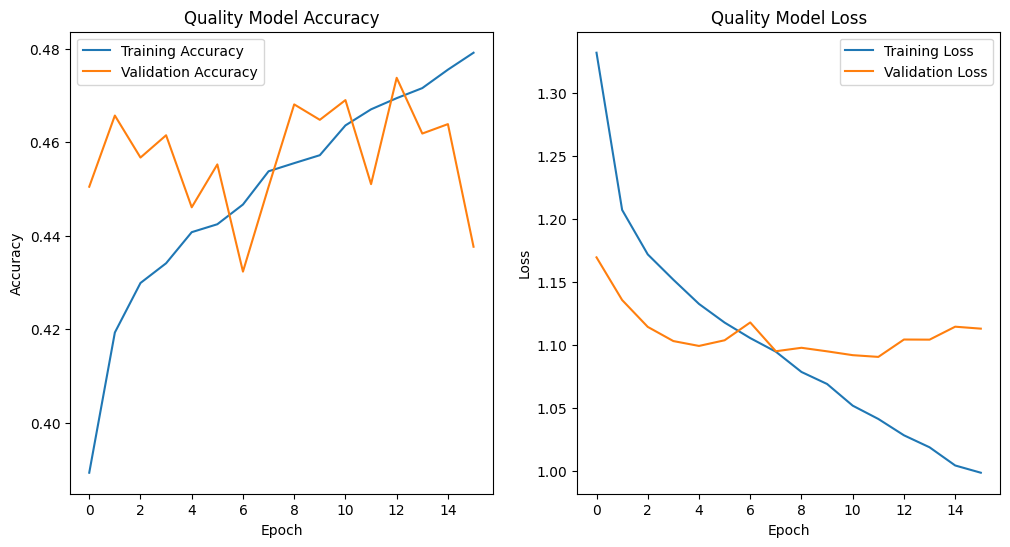

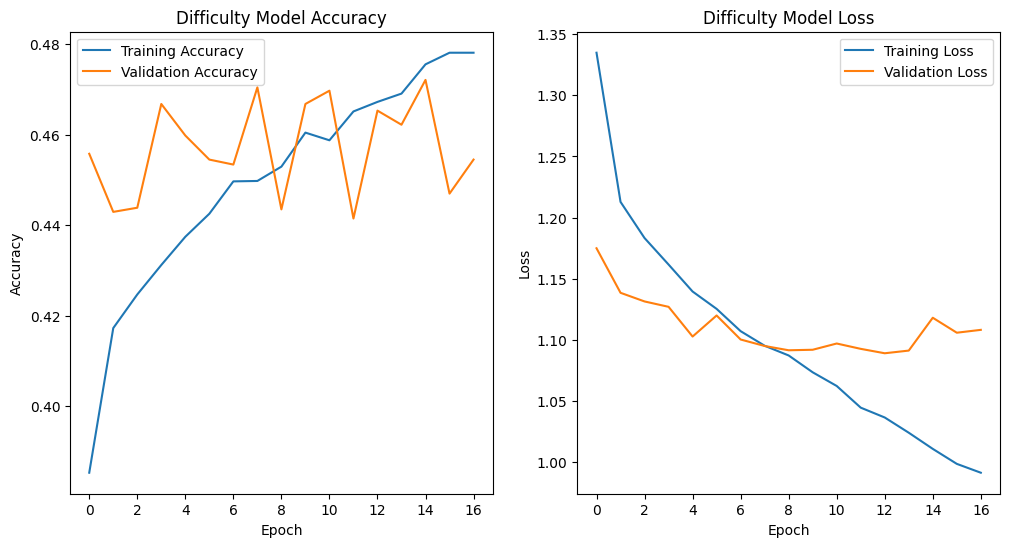

In [ ]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plotting training history for quality model
plot_training_history(bi_lstm_model_quality_history, 'Quality Model')

# Plotting training history for difficulty model
plot_training_history(bi_lstm_difficulty_history, 'Difficulty Model')


The training and validation accuracy show improvement, though validation accuracy fluctuates, suggesting potential variability in performance on unseen data.The training and validation loss decrease, with training loss showing a more consistent decline, indicating the model is learning effectively. Validation loss fluctuations suggest the model’s performance on unseen data can vary.

213/213 [==============================] - 2s 4ms/step


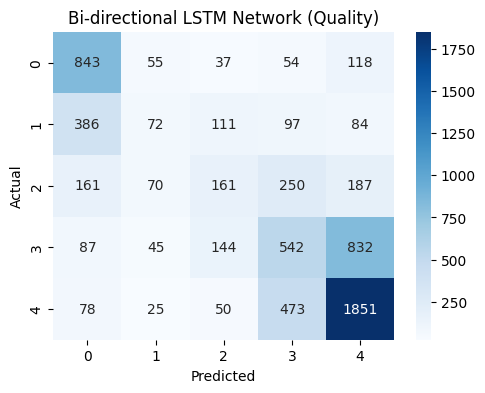

In [ ]:
# Confusion Matrix for Quality Model
quality_predictions = bi_lstm_quality.predict(X_quality_test)
quality_cm = confusion_matrix(y_quality_test.astype(int), quality_predictions.argmax(axis=1))
plt.figure(figsize=(5.5, 4))
sns.heatmap(quality_cm, annot=True, fmt='g', cmap='Blues')
plt.title("Bi-directional LSTM Network (Quality)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

The confusion matrix for the Bi-directional LSTM Network on the "Quality" classification task reveals that the model performs well in predicting class 4 with 1851 correct predictions, followed by reasonable performance for classes 0 (843 correct predictions) and 3 (542 correct predictions). However, there are significant misclassifications, particularly for class 1, which is often misclassified as class 0 (386 instances). Additionally, there is considerable confusion between classes 3 and 4, with many instances of class 3 being misclassified as class 4 (832 instances)

213/213 [==============================] - 2s 6ms/step


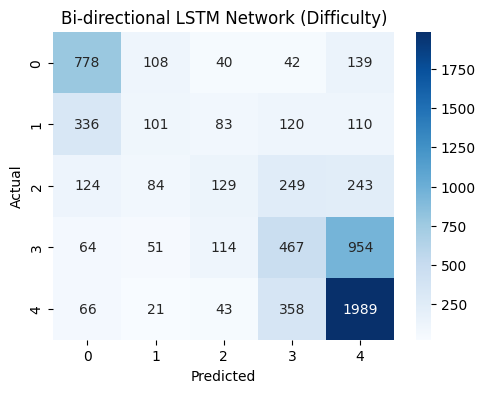

In [ ]:
# Confusion Matrix for Difficulty Model
difficulty_predictions = bi_lstm_difficulty.predict(X_difficulty_test)
difficulty_cm = confusion_matrix(y_difficulty_test.astype(int), difficulty_predictions.argmax(axis=1))
plt.figure(figsize=(5.5, 4))
sns.heatmap(difficulty_cm, annot=True, fmt='g', cmap='Blues')
plt.title("Bi-directional LSTM Network (Difficulty)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

The confusion matrix for the Bi-directional LSTM Network on the "Difficulty" classification task shows that the model performs best in predicting class 4, with 1989 correct predictions. It also performs reasonably well for classes 0 (778 correct predictions) and 3 (467 correct predictions). However, significant misclassifications occur, particularly for class 1, which is often misclassified as class 0 (336 instances). There is also notable confusion between classes 2 and 3, with many instances of class 2 being misclassified as class 3 (249 instances), and between classes 3 and 4, with many instances of class 3 being misclassified as class 4 (954 instances)

# **TRANSFORMER**

Now we try the same text classification task using the Transformer Architecture.For that we need to define the positional encoding for out dataset.We tried to utilize the pre defined postional encoding but due to compatabilty issues with the Keras_nlp library, we defined our own encoding function.   

The transformer_encoder function performs normalization and multi-head attention, followed by a feed-forward network with residual connections

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

The custom_transformer function builds a text classification model by embedding input sequences, applying two transformer encoder layers with specified parameters (head size, number of heads, feed-forward dimension, and dropout), and then performing global average pooling. This is followed by a dense layer with a hyperbolic tangent activation function and a final output layer with a softmax activation function for multi-class classification. The model uses pre-trained embeddings and is configured for a vocabulary of a given size and a maximum sequence length.

In [ ]:
def custom_transformer(vocab_length, embedding_matrix, max_len, num_classes=6):
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)
    x = embedding_layer
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
    x = GlobalAveragePooling1D()(x)
    x = Dense(16, activation="tanh")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


We are now using the custom_transformer function to create transformer model for Quality and Difficulty. we are also utilizing early stopping to monitor the validation loss, stopping training if there is no improvement for four consecutive epochs and restoring the best weights to prevent overfitting.

In [ ]:
transformer_model_quality = custom_transformer(vocab_length, embedding_matrix, max_len, num_classes=6)
transformer_model_difficulty = custom_transformer(vocab_length, embedding_matrix, max_len, num_classes=6)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [ ]:
transformer_model_quality.compile(loss='sparse_categorical_crossentropy',
                                  optimizer=Adam(learning_rate=1e-5),
                                  metrics=['accuracy'],
                                  run_eagerly=True)

transformer_model_quality.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 100, 100)             2064600   ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 100, 100)             200       ['embedding_2[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 100, 100)             103268    ['layer_normalization[0][0

In [ ]:
transformer_model_difficulty.compile(loss='sparse_categorical_crossentropy',
                                     optimizer=Adam(learning_rate=1e-5),
                                     metrics=['accuracy'],
                                     run_eagerly=True)


transformer_model_difficulty.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 100, 100)             2064600   ['input_2[0][0]']             
                                                                                                  
 layer_normalization_4 (Lay  (None, 100, 100)             200       ['embedding_3[0][0]']         
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_2 (Mu  (None, 100, 100)             103268    ['layer_normalization_4[

**Training the Transformer on Quality**

In [ ]:
history_quality_transformer = transformer_model_quality.fit(
    X_quality_train, y_quality_train,
    validation_data=(X_quality_valid, y_quality_valid),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


341/341 [==============================] - 49s 130ms/step - loss: 1.5551 - accuracy: 0.3206 - val_loss: 1.3565 - val_accuracy: 0.4222
Epoch 2/50
341/341 [==============================] - 47s 137ms/step - loss: 1.3781 - accuracy: 0.3872 - val_loss: 1.2684 - val_accuracy: 0.4407
Epoch 3/50
341/341 [==============================] - 46s 134ms/step - loss: 1.3187 - accuracy: 0.3974 - val_loss: 1.2541 - val_accuracy: 0.4450
Epoch 4/50
341/341 [==============================] - 44s 130ms/step - loss: 1.2984 - accuracy: 0.4019 - val_loss: 1.2321 - val_accuracy: 0.4415
Epoch 5/50
341/341 [==============================] - 44s 130ms/step - loss: 1.2914 - accuracy: 0.4011 - val_loss: 1.2385 - val_accuracy: 0.4365
Epoch 6/50
341/341 [==============================] - 49s 143ms/step - loss: 1.2812 - accuracy: 0.4004 - val_loss: 1.2280 - val_accuracy: 0.4393
Epoch 7/50
341/341 [==============================] - 47s 138ms/step - loss: 1.2717 - accuracy: 0.4050 - val_loss: 1.2224 - val_accuracy: 0.4

**Training the Transformer on Difficulty**

In [ ]:
history_difficulty_transformer = transformer_model_difficulty.fit(
    X_difficulty_train, y_difficulty_train,
    validation_data=(X_difficulty_valid, y_difficulty_valid),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
341/341 [==============================] - 54s 149ms/step - loss: 1.6399 - accuracy: 0.2951 - val_loss: 1.4422 - val_accuracy: 0.3756
Epoch 2/50
341/341 [==============================] - 44s 130ms/step - loss: 1.4420 - accuracy: 0.3692 - val_loss: 1.3336 - val_accuracy: 0.4029
Epoch 3/50
341/341 [==============================] - 43s 127ms/step - loss: 1.3750 - accuracy: 0.3934 - val_loss: 1.2896 - val_accuracy: 0.4072
Epoch 4/50
341/341 [==============================] - 43s 127ms/step - loss: 1.3370 - accuracy: 0.3983 - val_loss: 1.2742 - val_accuracy: 0.4189
Epoch 5/50
341/341 [==============================] - 43s 126ms/step - loss: 1.3224 - accuracy: 0.4030 - val_loss: 1.2546 - val_accuracy: 0.4288
Epoch 6/50
341/341 [==============================] - 47s 138ms/step - loss: 1.3114 - accuracy: 0.4020 - val_loss: 1.2569 - val_accuracy: 0.4171
Epoch 7/50
341/341 [==============================] - 43s 127ms/step - loss: 1.2981 - accuracy: 0.4035 - val_loss: 1.2499 - val_ac

In [ ]:
quality_loss_transformer, quality_accuracy_transformer = transformer_model_quality.evaluate(X_quality_test, y_quality_test, verbose=False)
print(f"Quality Transformer Model - Loss: {quality_loss_transformer}, Accuracy: {quality_accuracy_transformer}")


Quality Transformer Model - Loss: 1.2281197309494019, Accuracy: 0.41435492038726807


In [ ]:
difficulty_loss_transformer, difficulty_accuracy_transformer = transformer_model_difficulty.evaluate(X_difficulty_test, y_difficulty_test, verbose=False)
print(f"Difficulty Transformer Model - Loss: {difficulty_loss_transformer}, Accuracy: {difficulty_accuracy_transformer}")


Difficulty Transformer Model - Loss: 1.2133402824401855, Accuracy: 0.41523557901382446


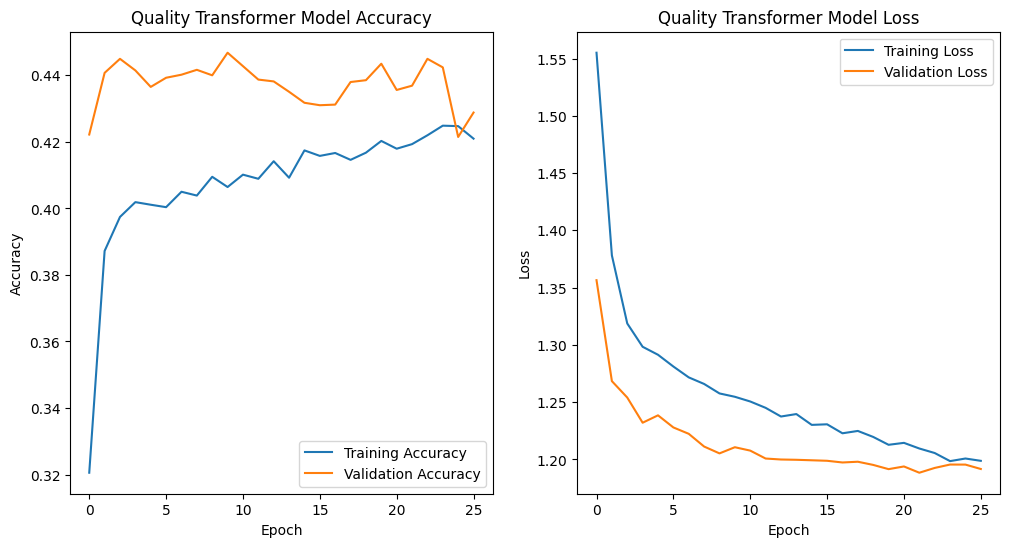

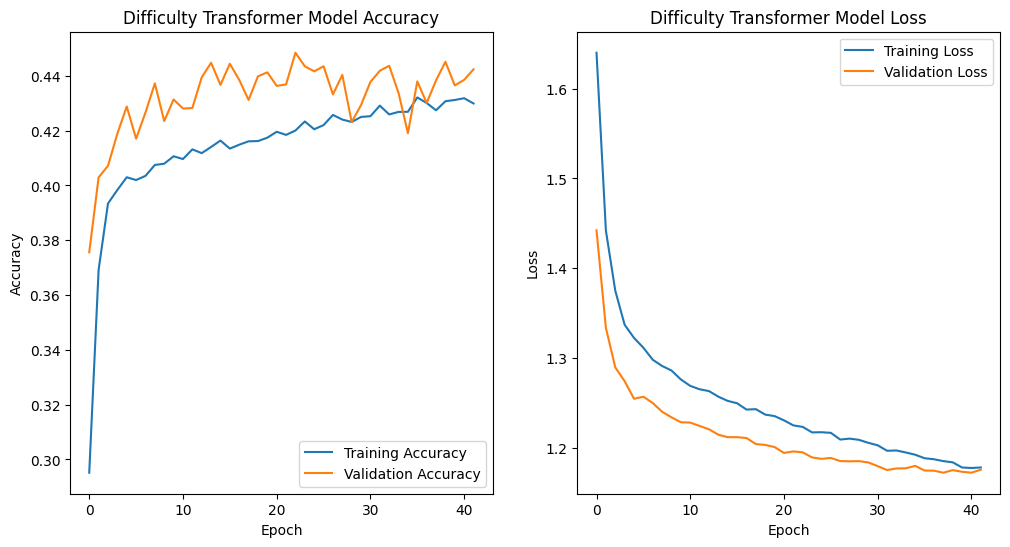

In [ ]:
plot_training_history(history_quality_transformer, 'Quality Transformer Model')

plot_training_history(history_difficulty_transformer, 'Difficulty Transformer Model')

The training and validation performance graphs for both the Quality and Difficulty Transformer Models indicate effective learning, with steady decreases in training and validation loss, demonstrating improved model fit over time. For the Quality Model, training accuracy steadily increases from around 0.32 to 0.42, while validation accuracy fluctuates, ending near 0.42. The Difficulty Model shows similar trends, with training accuracy rising from 0.30 to 0.42 and validation accuracy fluctuating but generally higher, ending near 0.44. Both models exhibit consistent decreases in loss, with training loss falling to around 1.20 for both models and validation loss showing minor fluctuations but ultimately converging near 1.20

213/213 [==============================] - 11s 50ms/step


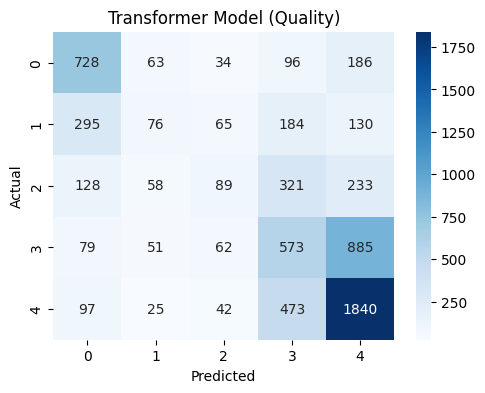

In [ ]:
# Confusion Matrix for Quality Model
quality_predictions_transformer = transformer_model_quality.predict(X_quality_test)
quality_cm_transformer = confusion_matrix(y_quality_test.astype(int), quality_predictions_transformer.argmax(axis=1))
plt.figure(figsize=(5.5, 4))
sns.heatmap(quality_cm_transformer, annot=True, fmt='g', cmap='Blues')
plt.title("Transformer Model (Quality)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


The confusion matrix for the Quality Transformer Model shows that the model performs best in predicting class 4, with 1840 correct predictions. It also performs reasonably well for classes 0 (728 correct predictions) and 3 (573 correct predictions). However, significant misclassifications occur, particularly for class 1, which is often misclassified as class 0 (295 instances). There is also notable confusion between classes 2 and 3, with many instances of class 2 being misclassified as class 3 (321 instances), and between classes 3 and 4, with many instances of class 3 being misclassified as class 4 (885 instances).

213/213 [==============================] - 14s 63ms/step


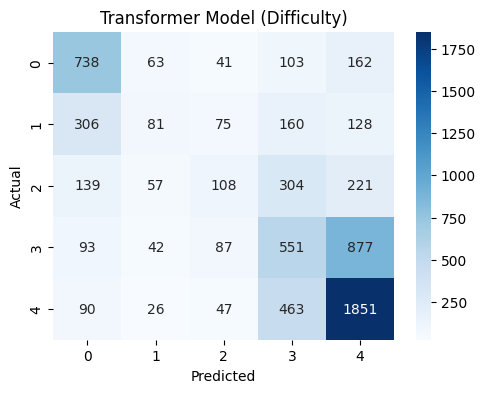

In [ ]:
difficulty_predictions_transformer = transformer_model_difficulty.predict(X_difficulty_test)
difficulty_cm_transformer = confusion_matrix(y_difficulty_test.astype(int), difficulty_predictions_transformer.argmax(axis=1))
plt.figure(figsize=(5.5, 4))
sns.heatmap(difficulty_cm_transformer, annot=True, fmt='g', cmap='Blues')
plt.title("Transformer Model (Difficulty)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

The confusion matrix for the Difficulty Transformer Model shows that the model performs best in predicting class 4, with 1851 correct predictions. It also performs reasonably well for classes 0 (738 correct predictions) and 3 (551 correct predictions). However, there are significant misclassifications, particularly for class 1, which is often misclassified as class 0 (306 instances). Additionally, there is notable confusion between classes 2 and 3, with many instances of class 2 being misclassified as class 3 (304 instances), and between classes 3 and 4, with many instances of class 3 being misclassified as class 4 (877 instances)

**Comparision Between RNN and Transformer**

On comparing the performance of Bi-LSTM and Transformer models for quality and difficulty classification tasks reveals that Bi-LSTM models generally outperform Transformer models in terms of accuracy and loss. The Bi-LSTM Quality Model achieves an accuracy of 0.4292 and a loss of 1.1188, compared to the Transformer Quality Model's accuracy of 0.4144 and loss of 1.2281. Similarly, the Bi-LSTM Difficulty Model achieves an accuracy of 0.4395 and a loss of 1.1249, whereas the Transformer Difficulty Model achieves an accuracy of 0.4152 and a loss of 1.2133. Both models exhibit significant misclassifications, particularly between adjacent classes, indicating challenges in differentiating similar categories, We observe that Bi-LSTM performs slightly better when compared with transformer, in this case, it may be because of the quantity of the available data, as conventionally transformers require large amounts of data.

Loss Comparison
Quality Task:

Bi-LSTM Model: Loss = 1.1188
Transformer Model: Loss = 1.2281
The Bi-LSTM model shows lower loss, indicating better performance in minimizing the error.
Difficulty Task:

Bi-LSTM Model: Loss = 1.1249
Transformer Model: Loss = 1.2133
Similarly, the Bi-LSTM model has lower loss here as well.
Accuracy Comparison
Quality Task:

Bi-LSTM Model: Accuracy = 0.4292
Transformer Model: Accuracy = 0.4144
The Bi-LSTM model has higher accuracy, showing it is better at correctly predicting the quality classification.
Difficulty Task:

Bi-LSTM Model: Accuracy = 0.4395
Transformer Model: Accuracy = 0.4152
Again, the Bi-LSTM model outperforms the Transformer model in accuracy.

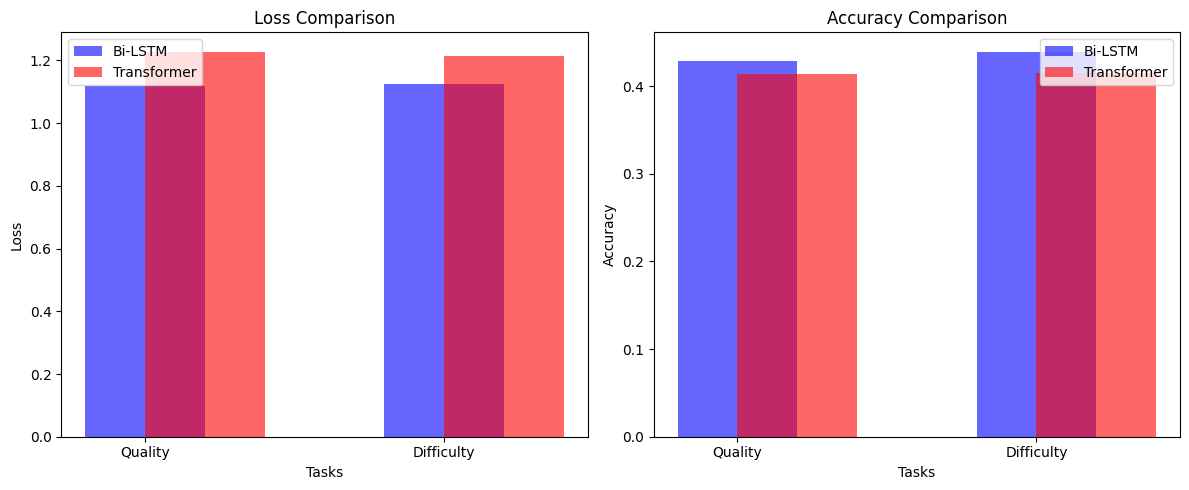

In [ ]:
import matplotlib.pyplot as plt

# Data for the models
tasks = ['Quality', 'Difficulty']
bilstm_loss = [1.1188, 1.1249]
bilstm_accuracy = [0.4292, 0.4395]

transformer_loss = [1.2281, 1.2133]
transformer_accuracy = [0.4144, 0.4152]

# Plotting the Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(tasks, bilstm_loss, width=0.4, color='blue', alpha=0.6, label='Bi-LSTM', align='center')
plt.bar(tasks, transformer_loss, width=0.4, color='red', alpha=0.6, label='Transformer', align='edge')
plt.xlabel('Tasks')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

# Plotting the Accuracy
plt.subplot(1, 2, 2)
plt.bar(tasks, bilstm_accuracy, width=0.4, color='blue', alpha=0.6, label='Bi-LSTM', align='center')
plt.bar(tasks, transformer_accuracy, width=0.4, color='red', alpha=0.6, label='Transformer', align='edge')
plt.xlabel('Tasks')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()
